# Jayadeep

In [1]:
# Step 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Step 2: Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Define activation functions
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    e_x = np.exp(x - np.max(x))  # stability improvement
    return e_x / e_x.sum(axis=0)

def show_image(img, title="Image"):
    img = img / 2 + 0.5  # Unnormalize
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()



In [3]:

# Convolution function
def convolve2d(image, kernels, stride=1, padding=0, activation=relu):
    if padding > 0:
        image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant')

    kernel_height, kernel_width, _, num_kernels = kernels.shape
    output_height = (image.shape[0] - kernel_height) // stride + 1
    output_width = (image.shape[1] - kernel_width) // stride + 1
    
    output = np.zeros((output_height, output_width, num_kernels))
    
    for i in range(num_kernels):  # Iterate over each kernel
        kernel = kernels[:, :, :, i]  # Get the i-th kernel
        for y in range(output_height):
            for x in range(output_width):
                output[y, x, i] = np.sum(image[y*stride:y*stride+kernel_height, x*stride:x*stride+kernel_width, :] * kernel)
    
    return activation(output)

In [4]:
# Pooling function
def pooling2d(image, pool_size=2, stride=2, mode='max'):
    output_height = (image.shape[0] - pool_size) // stride + 1
    output_width = (image.shape[1] - pool_size) // stride + 1
    output = np.zeros((output_height, output_width, image.shape[2]))
    
    for y in range(output_height):
        for x in range(output_width):
            for c in range(image.shape[2]):
                if mode == 'max':
                    output[y, x, c] = np.max(image[y*stride:y*stride+pool_size, x*stride:x*stride+pool_size, c])
                elif mode == 'average':
                    output[y, x, c] = np.mean(image[y*stride:y*stride+pool_size, x*stride:x*stride+pool_size, c])
    
    return output


In [5]:
# Flatten function
def flatten(image):
    return image.flatten()


In [6]:
# MLP class definition
class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.weights = [
            np.random.randn(input_size, hidden_size),
            np.random.randn(hidden_size, output_size)
        ]
        self.biases = [
            np.random.randn(hidden_size),
            np.random.randn(output_size)
        ]

    def forward(self, x):
        for weight, bias in zip(self.weights, self.biases):
            x = relu(np.dot(x, weight) + bias)
        return x


In [7]:

# CNN class definition
class SimpleCNN:
    def __init__(self):
        # Initialize filters (kernels) randomly
        self.conv1_kernels = np.random.randn(5, 5, 3, 6)  # 6 kernels, 5x5 size, 3 channels
        self.conv2_kernels = np.random.randn(5, 5, 6, 16)  # 16 kernels, 5x5 size, 6 channels
        self.mlp = MLP(16 * 8 * 8, 120, 10)  # Updated input size after pooling

    def forward(self, image):
        # First Convolution Layer
        conv1_out = convolve2d(image, self.conv1_kernels, stride=1, padding=2)
        # Max Pooling Layer
        pool1_out = pooling2d(conv1_out, pool_size=2, stride=2)
        # Second Convolution Layer
        conv2_out = convolve2d(pool1_out, self.conv2_kernels, stride=1, padding=2)
        # Max Pooling Layer
        pool2_out = pooling2d(conv2_out, pool_size=2, stride=2)
        # Flattening Layer
        flat_out = flatten(pool2_out)
        # Fully Connected Layer
        output_vector = self.mlp.forward(flat_out)
        return softmax(output_vector)




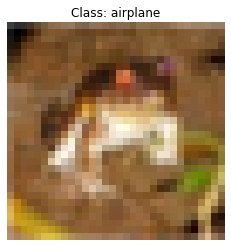

Output vector for class 'airplane': [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


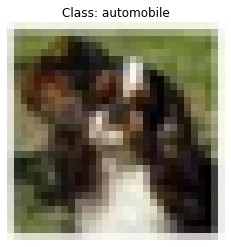

Output vector for class 'automobile': [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


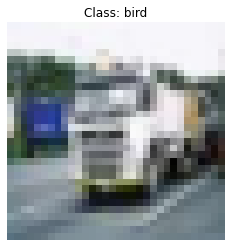

Output vector for class 'bird': [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


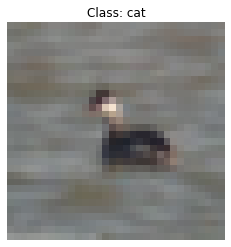

Output vector for class 'cat': [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


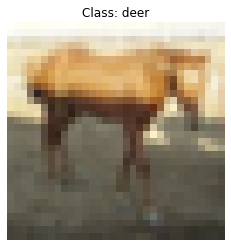

Output vector for class 'deer': [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


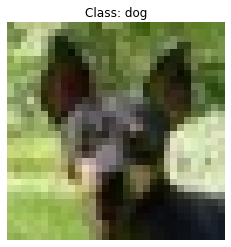

Output vector for class 'dog': [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


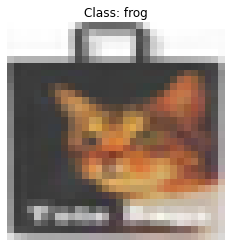

Output vector for class 'frog': [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


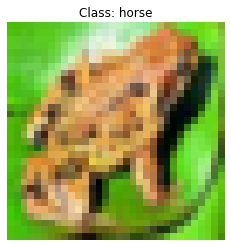

Output vector for class 'horse': [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


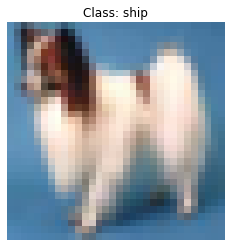

Output vector for class 'ship': [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


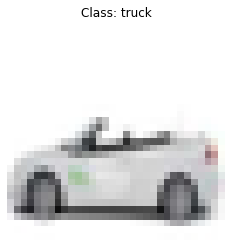

Output vector for class 'truck': [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [8]:
# Initialize CNN
cnn = SimpleCNN()

# Step 11: Test the CNN with images from each class
class_labels = trainset.classes

for i in range(10):  # For each class
    sample_image, _ = trainset[i * 500]  # Get an image from each class
    sample_image_np = sample_image.numpy().transpose(1, 2, 0)  # Convert to numpy and reshape
    show_image(sample_image_np, title=f"Class: {class_labels[i]}")  # Show image

    output_vector = cnn.forward(sample_image_np)  # Forward pass
    print(f"Output vector for class '{class_labels[i]}':", output_vector)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)  # Convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)        # Pooling layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2) # Second convolutional layer
        self.fc1 = nn.Linear(64 * 8 * 8, 128)                    # Fully connected layer
        self.fc2 = nn.Linear(128, 10)                             # Output layer
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [14]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Select 100 samples per class for training
train_samples = [trainset.targets.index(i) for i in range(10) for _ in range(100)]
train_subset = torch.utils.data.Subset(trainset, train_samples)

# Data loaders
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [15]:
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, epochs=15):
    train_losses = []
    test_losses = []
    accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Record training loss
        train_losses.append(running_loss / len(trainloader))
        
        # Calculate test loss and accuracy
        test_loss, correct = 0.0, 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                pred = outputs.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()
        
        test_losses.append(test_loss / len(testloader))
        accuracy = 100. * correct / len(testloader.dataset)
        accuracies.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%')
    
    return train_losses, test_losses, accuracies


In [16]:
class SimpleCNNWithDropout(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(SimpleCNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))  # Apply dropout
        x = self.fc2(x)
        return x


In [17]:
# Example: Training with vanilla SGD
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

train_losses, test_losses, accuracies = train_model(model, criterion, optimizer)


Epoch [1/15], Training Loss: 2.2893, Test Loss: 2.3010, Accuracy: 10.00%
Epoch [2/15], Training Loss: 2.2660, Test Loss: 2.2992, Accuracy: 12.01%
Epoch [3/15], Training Loss: 2.2418, Test Loss: 2.2979, Accuracy: 12.45%
Epoch [4/15], Training Loss: 2.2114, Test Loss: 2.2971, Accuracy: 11.14%
Epoch [5/15], Training Loss: 2.1697, Test Loss: 2.2978, Accuracy: 9.91%
Epoch [6/15], Training Loss: 2.1102, Test Loss: 2.3021, Accuracy: 9.59%
Epoch [7/15], Training Loss: 2.0213, Test Loss: 2.3127, Accuracy: 10.20%
Epoch [8/15], Training Loss: 1.8834, Test Loss: 2.3226, Accuracy: 10.92%
Epoch [9/15], Training Loss: 1.6618, Test Loss: 2.3532, Accuracy: 11.34%
Epoch [10/15], Training Loss: 1.3308, Test Loss: 2.4895, Accuracy: 10.98%
Epoch [11/15], Training Loss: 0.9340, Test Loss: 2.6892, Accuracy: 11.59%
Epoch [12/15], Training Loss: 0.5803, Test Loss: 3.0130, Accuracy: 12.70%
Epoch [13/15], Training Loss: 0.3599, Test Loss: 3.3991, Accuracy: 12.03%
Epoch [14/15], Training Loss: 0.2409, Test Loss: 

In [18]:
for rate in [0.2, 0.5, 0.8]:
    model = SimpleCNNWithDropout(dropout_rate=rate)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
    train_losses, test_losses, accuracies = train_model(model, criterion, optimizer)
    # Store and compare results


Epoch [1/15], Training Loss: 0.6992, Test Loss: 4.4620, Accuracy: 13.69%
Epoch [2/15], Training Loss: 0.0215, Test Loss: 5.1015, Accuracy: 15.95%
Epoch [3/15], Training Loss: 0.0003, Test Loss: 7.4179, Accuracy: 15.17%
Epoch [4/15], Training Loss: 0.0431, Test Loss: 6.9537, Accuracy: 15.35%
Epoch [5/15], Training Loss: 0.0001, Test Loss: 10.0993, Accuracy: 13.65%
Epoch [6/15], Training Loss: 0.0335, Test Loss: 11.8485, Accuracy: 13.32%
Epoch [7/15], Training Loss: 0.0000, Test Loss: 9.8891, Accuracy: 15.07%
Epoch [8/15], Training Loss: 0.0001, Test Loss: 13.4609, Accuracy: 14.28%
Epoch [9/15], Training Loss: 0.0001, Test Loss: 16.7023, Accuracy: 13.65%
Epoch [10/15], Training Loss: 0.0000, Test Loss: 13.9721, Accuracy: 14.72%
Epoch [11/15], Training Loss: 0.0000, Test Loss: 15.8681, Accuracy: 14.02%
Epoch [12/15], Training Loss: 0.0000, Test Loss: 18.9246, Accuracy: 13.84%
Epoch [13/15], Training Loss: 0.0000, Test Loss: 19.0756, Accuracy: 12.66%
Epoch [14/15], Training Loss: 0.0041, T

In [19]:
# Example: Adjusting the learning rate and using Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Try Adam optimizer

# Example: Adding Batch Normalization to the model
class SimpleCNNWithBatchNorm(nn.Module):
    def __init__(self):
        super(SimpleCNNWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Apply Batch Norm
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Apply Batch Norm
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize and train with the new model
model = SimpleCNNWithBatchNorm()


In [20]:
 # Example: Training with vanilla SGD
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

train_losses, test_losses, accuracies = train_model(model, criterion, optimizer)


Epoch [1/15], Training Loss: 2.2903, Test Loss: 2.3019, Accuracy: 9.24%
Epoch [2/15], Training Loss: 2.2734, Test Loss: 2.3011, Accuracy: 9.70%
Epoch [3/15], Training Loss: 2.2578, Test Loss: 2.3002, Accuracy: 10.06%
Epoch [4/15], Training Loss: 2.2385, Test Loss: 2.2993, Accuracy: 9.82%
Epoch [5/15], Training Loss: 2.2135, Test Loss: 2.2986, Accuracy: 9.27%
Epoch [6/15], Training Loss: 2.1805, Test Loss: 2.2986, Accuracy: 9.18%
Epoch [7/15], Training Loss: 2.1351, Test Loss: 2.2995, Accuracy: 9.40%
Epoch [8/15], Training Loss: 2.0674, Test Loss: 2.3035, Accuracy: 10.25%
Epoch [9/15], Training Loss: 1.9644, Test Loss: 2.3111, Accuracy: 10.37%
Epoch [10/15], Training Loss: 1.8030, Test Loss: 2.3242, Accuracy: 10.71%
Epoch [11/15], Training Loss: 1.5555, Test Loss: 2.3671, Accuracy: 12.71%
Epoch [12/15], Training Loss: 1.2151, Test Loss: 2.4815, Accuracy: 13.42%
Epoch [13/15], Training Loss: 0.8398, Test Loss: 2.6858, Accuracy: 13.71%
Epoch [14/15], Training Loss: 0.5354, Test Loss: 3.01

In [21]:
for rate in [0.2, 0.5, 0.8]:
    model = SimpleCNNWithDropout(dropout_rate=rate)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
    train_losses, test_losses, accuracies = train_model(model, criterion, optimizer)
    # Store and compare results


Epoch [1/15], Training Loss: 0.3916, Test Loss: 4.2267, Accuracy: 14.62%
Epoch [2/15], Training Loss: 0.0316, Test Loss: 5.4856, Accuracy: 13.52%
Epoch [3/15], Training Loss: 0.0003, Test Loss: 5.4225, Accuracy: 13.59%
Epoch [4/15], Training Loss: 0.0003, Test Loss: 6.5826, Accuracy: 14.24%
Epoch [5/15], Training Loss: 0.0000, Test Loss: 9.5591, Accuracy: 14.98%
Epoch [6/15], Training Loss: 0.0000, Test Loss: 12.0267, Accuracy: 14.37%
Epoch [7/15], Training Loss: 0.0082, Test Loss: 9.4729, Accuracy: 13.21%
Epoch [8/15], Training Loss: 0.0000, Test Loss: 9.0612, Accuracy: 13.58%
Epoch [9/15], Training Loss: 0.0064, Test Loss: 11.1705, Accuracy: 13.98%
Epoch [10/15], Training Loss: 0.0000, Test Loss: 10.8314, Accuracy: 14.09%
Epoch [11/15], Training Loss: 0.0000, Test Loss: 10.4624, Accuracy: 14.74%
Epoch [12/15], Training Loss: 0.0000, Test Loss: 11.4214, Accuracy: 14.45%
Epoch [13/15], Training Loss: 0.0016, Test Loss: 19.3066, Accuracy: 15.31%
Epoch [14/15], Training Loss: 0.0000, Tes